In [1]:
import xarray as xr
import numpy as np
import os

import scipy as sp
import sys
import pandas as pd
import datetime


In [2]:
region="EQ"
latN=15
latS=-15
lonW=30
lonE=120

In [3]:
wave = "er"
var = "vr_total_source"
mode= "wet"
ens = "ensmean"

folder_model = f"/g/data/v46/fm6730/dataout/lifecycle/vorticity_budget/{wave}/{mode}/"
file_model = f"hovmuller_lon133_{mode}_{wave}_NDJFMA_vorticity_budget_{ens}_leaddays.nc"
ds_model = xr.open_dataset(folder_model+file_model)
ds_model = ds_model.sel(lon=slice(lonW,lonE))

In [4]:
print(ds_model)

<xarray.Dataset>
Dimensions:                (time: 60, lon: 37)
Coordinates:
  * time                   (time) int64 0 1 2 3 4 5 6 7 ... 53 54 55 56 57 58 59
  * lon                    (lon) float32 30.0 32.5 35.0 ... 115.0 117.5 120.0
Data variables: (12/26)
    vr_mod                 (time, lon) float64 ...
    vr_dia                 (time, lon) float64 ...
    div_mod                (time, lon) float64 ...
    div_dia                (time, lon) float64 ...
    vrD_mod                (time, lon) float64 ...
    vrD_dia                (time, lon) float64 ...
    ...                     ...
    vr_tilt_mod            (time, lon) float64 ...
    vr_tilt_dia            (time, lon) float64 ...
    vr_stretch_mod         (time, lon) float64 ...
    vr_stretch_dia         (time, lon) float64 ...
    dvr_dt_mod             (time, lon) float64 ...
    dvr_dt_dia             (time, lon) float64 ...


In [5]:
from scipy.signal import find_peaks, peak_prominences

In [130]:
# tt = np.linspace(0,len(rmsa_model_normalised['dvr_dt'].time),1)
yy = ds_model.isel(time=slice(0,60))
tt = np.arange(0,len(yy),1)

def find_peaks_and_widths(yy,var,lonL=30,lonR=140,dlon=0,height=0):
    varout = np.empty((3,len(yy[var].time)), dtype=object)
    c = 0
    for t in yy[var].time:
        data = yy[var].sel(time=t, lon=slice(lonL,lonR))
        tmp_peaks,_ = find_peaks(data.to_numpy(), height=height)
        _,left_bases,right_bases = peak_prominences(data.to_numpy(), tmp_peaks)


        varout[0,c] = data.lon.isel(lon=tmp_peaks).values
        varout[1,c] = left_bases.squeeze()
        varout[2,c] = right_bases.squeeze()

        print(lonL,lonR)
        lonL+=dlon
        lonR+=dlon

        del(data,tmp_peaks,left_bases,right_bases)
        c+=1
        

    return varout



In [131]:
res = find_peaks_and_widths(yy,'dvr_dt_dia',height=0)


30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140
30 140


In [181]:
res

array([[array([ 35. ,  72.5, 112.5], dtype=float32),
        array([ 32.5,  67.5, 110. ], dtype=float32),
        array([ 32.5,  65. , 105. ], dtype=float32),
        array([ 62.5, 102.5], dtype=float32),
        array([ 60., 100.], dtype=float32),
        array([55., 95.], dtype=float32),
        array([52.5, 92.5], dtype=float32),
        array([50., 90.], dtype=float32),
        array([47.5, 87.5], dtype=float32),
        array([45. , 82.5], dtype=float32),
        array([42.5, 80. ], dtype=float32),
        array([40. , 77.5], dtype=float32),
        array([35., 75.], dtype=float32),
        array([ 32.5,  72.5, 117.5], dtype=float32),
        array([ 70., 115.], dtype=float32),
        array([ 65. , 112.5], dtype=float32),
        array([ 62.5, 107.5], dtype=float32),
        array([ 60., 105.], dtype=float32),
        array([ 57.5, 102.5], dtype=float32),
        array([ 55., 100.], dtype=float32),
        array([50. , 97.5], dtype=float32),
        array([47.5, 95. ], dtype=floa

In [182]:
# ...existing code...
import numpy as np

def track_highest_then_nearest(res, data_da):
    """
    As before but also extract corresponding values from res[2][:] and res[3][:]
    (or from res[1],res[2] if the array only has 3 rows). Returns (track, left_vals, right_vals)
    where left_vals/right_vals hold the respective res[*] value for the chosen peak at each time
    (np.nan when no peak).
    """
    ntime = len(res[0])
    track = np.full(ntime, np.nan, dtype=float)
    left_vals = np.full(ntime, np.nan, dtype=float)
    right_vals = np.full(ntime, np.nan, dtype=float)

    # helper to get lon array for a time index (robust to scalars / empty)
    def get_lons_at(t):
        arr = res[0][t]
        if arr is None:
            return np.array([], dtype=float)
        a = np.atleast_1d(arr)
        return a[np.isfinite(a)].astype(float)

    # helper to get associated left/right arrays for a time index
    def get_assoc_at(t):
        nrows = res.shape[0]
        # prefer res[2],res[3] if present (user request), otherwise fall back to res[1],res[2]
        if nrows >= 4:
            A = res[2][t]
            B = res[3][t]
        elif nrows >= 3:
            A = res[1][t]
            B = res[2][t]
        else:
            return np.array([], dtype=float), np.array([], dtype=float)
        a = np.atleast_1d(A).astype(float)
        b = np.atleast_1d(B).astype(float)
        # ensure lengths match number of peaks (if scalars, return arrays of length 1)
        return a[np.isfinite(a)], b[np.isfinite(b)]

    # time 0: pick highest by value
    lons0 = get_lons_at(0)
    if lons0.size == 0:
        return track, left_vals, right_vals
    t0 = data_da.time.isel(time=0).values
    vals0 = data_da.sel(time=t0, lon=lons0, method='nearest').values
    vals0 = np.atleast_1d(vals0).astype(float)
    idx0 = int(np.nanargmax(vals0))
    track[0] = lons0[idx0]
    prev_lon = track[0]
    # store associated left/right if available
    a0, b0 = get_assoc_at(0)
    if a0.size > idx0:
        left_vals[0] = a0[idx0]
    if b0.size > idx0:
        right_vals[0] = b0[idx0]

    # subsequent times: nearest to previous, tie-break by height
    for ti in range(1, ntime):
        lons_t = get_lons_at(ti)
        if lons_t.size == 0:
            track[ti] = np.nan
            left_vals[ti] = np.nan
            right_vals[ti] = np.nan
            continue
        diffs = np.abs(lons_t - prev_lon)
        min_diff = diffs.min()
        cand_idx = np.where(diffs == min_diff)[0]
        if cand_idx.size == 1:
            pick = int(cand_idx[0])
        else:
            # tie-break by height at this time
            tt = data_da.time.isel(time=ti).values
            cand_lons = lons_t[cand_idx]
            cand_vals = data_da.sel(time=tt, lon=cand_lons, method='nearest').values
            cand_vals = np.atleast_1d(cand_vals).astype(float)
            pick = int(cand_idx[int(np.nanargmax(cand_vals))])
        track[ti] = lons_t[pick]
        prev_lon = track[ti]

        # store associated left/right if available
        a_t, b_t = get_assoc_at(ti)
        if a_t.size > pick:
            left_vals[ti] = a_t[pick]
        if b_t.size > pick:
            right_vals[ti] = b_t[pick]

    return track, left_vals, right_vals

# Example usage:
# track, left_bases, right_bases = track_highest_then_nearest(res, yy['dvr_dt_dia'])
# ...existing code...

In [183]:
track = track_highest_then_nearest(res, yy['dvr_dt_dia'])

In [185]:
track

(array([112.5, 110. , 105. , 102.5, 100. ,  95. ,  92.5,  90. ,  87.5,
         82.5,  80. ,  77.5,  75. ,  72.5,  70. ,  65. ,  62.5,  60. ,
         57.5,  55. ,  50. ,  47.5,  42.5,  40. ,  35. ,  85. ,  80. ,
         77.5,  75. ,  72.5,  70. ,  67.5,  65. ,  62.5,  60. ,  60. ,
         57.5,  57.5,  55. ,  52.5,  50. ,  47.5,  45. ,  42.5,  37.5,
         35. ,  92.5,  87.5,  85. ,  82.5,  77.5,  75. ,  70. ,  67.5,
         65. ,  60. ,  57.5,  55. ,  50. ,  47.5]),
 array([25., 23., 22., 21., 20., 18., 17., 16., 15., 13., 12., 11., 10.,
         9.,  7.,  6.,  5.,  3.,  2.,  0.,  0.,  0.,  0.,  0.,  0., 12.,
        11.,  9.,  9.,  8.,  8.,  8.,  7.,  7.,  6.,  5.,  4.,  3.,  2.,
         1.,  0.,  0.,  0.,  0.,  0.,  0., 15., 13., 12., 10.,  9.,  7.,
         6.,  5.,  4.,  3.,  2.,  1.,  0.,  0.]),
 array([36., 36., 36., 36., 36., 36., 34., 33., 32., 30., 29., 28., 27.,
        25., 24., 23., 22., 21., 20., 19., 17., 16., 15., 14., 13., 32.,
        30., 29., 28., 26., 25., 2

In [186]:
track_peak = xr.DataArray(track[0], coords=[yy.time], dims=["time"])
track_left = xr.DataArray(track[1], coords=[yy.time], dims=["time"])
track_right = xr.DataArray(track[2], coords=[yy.time], dims=["time"])

In [224]:
track_left

<xarray.DataArray (time: 60)>
array([25., 23., 22., 21., 20., 18., 17., 16., 15., 13., 12., 11., 10.,
        9.,  7.,  6.,  5.,  3.,  2.,  0.,  0.,  0.,  0.,  0.,  0., 12.,
       11.,  9.,  9.,  8.,  8.,  8.,  7.,  7.,  6.,  5.,  4.,  3.,  2.,
        1.,  0.,  0.,  0.,  0.,  0.,  0., 15., 13., 12., 10.,  9.,  7.,
        6.,  5.,  4.,  3.,  2.,  1.,  0.,  0.])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58 59

In [ ]:

tmp = np.empty((len(ds_model.time)), dtype=float)
# print(tmp)
dict_tracked={}
for v in ds_tracked.data_vars:
    t = 0
    for l,r in zip(track[1], track[2]):
        print("l,r,t",l,r,t )

        tmp[t] = ds_model.isel(time=t, lon=slice(l.astype(int),r.astype(int))).mean().values()
        t+=1
        # print(CEK.shape)

    
    dict_tracked[v] = tmp
    del(tmp)


[0.00e+000 4.94e-324 9.88e-324 1.48e-323 1.98e-323 2.47e-323 2.96e-323
 3.46e-323 3.95e-323 4.45e-323 4.94e-323 5.43e-323 5.93e-323 6.42e-323
 6.92e-323 7.41e-323 7.91e-323 8.40e-323 8.89e-323 9.39e-323 9.88e-323
 1.04e-322 1.09e-322 1.14e-322 1.19e-322 1.24e-322 1.28e-322 1.33e-322
 1.38e-322 1.43e-322 1.48e-322 1.53e-322 1.58e-322 1.63e-322 1.68e-322
 1.73e-322 1.78e-322 1.83e-322 1.88e-322 1.93e-322 1.98e-322 2.03e-322
 2.08e-322 2.12e-322 2.17e-322 2.22e-322 2.27e-322 2.32e-322 2.37e-322
 2.42e-322 2.47e-322 2.52e-322 2.57e-322 2.62e-322 2.67e-322 2.72e-322
 2.77e-322 2.82e-322 2.87e-322 2.91e-322]
l,r,t 25.0 36.0 0


TypeError: float() argument must be a string or a number, not 'ValuesView'

In [236]:
tmp

array([[4.67253183e-310, 4.67253283e-310, 4.67253183e-310, ...,
        1.65515672e-312, 1.67637668e-312, 6.90051811e-310],
       [4.67253342e-310, 6.57818695e-313, 4.67253342e-310, ...,
        4.67242253e-310, 6.90073031e-310, 1.95223613e-312],
       [2.03711596e-312, 4.24399158e-313, 6.90078792e-310, ...,
        4.67253342e-310, 4.67253342e-310, 4.67253342e-310],
       ...,
       [0.00000000e+000, 2.47032823e-323, 1.06099927e-313, ...,
        3.45845952e-323, 1.69759800e-313, 0.00000000e+000],
       [3.45845952e-323, 1.69759777e-313, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000]])

In [211]:
tmp

<xarray.Dataset>
Dimensions:                (time: 60, lon: 0)
Coordinates:
  * time                   (time) int64 0 1 2 3 4 5 6 7 ... 53 54 55 56 57 58 59
  * lon                    (lon) float32 
Data variables: (12/26)
    vr_mod                 (time, lon) float64 ...
    vr_dia                 (time, lon) float64 ...
    div_mod                (time, lon) float64 ...
    div_dia                (time, lon) float64 ...
    vrD_mod                (time, lon) float64 ...
    vrD_dia                (time, lon) float64 ...
    ...                     ...
    vr_tilt_mod            (time, lon) float64 ...
    vr_tilt_dia            (time, lon) float64 ...
    vr_stretch_mod         (time, lon) float64 ...
    vr_stretch_dia         (time, lon) float64 ...
    dvr_dt_mod             (time, lon) float64 ...
    dvr_dt_dia             (time, lon) float64 ...

In [203]:
ds_tracked_mean = ds_model.isel(time=slice(0,20)).mean(dim=['time','lon'])

In [204]:
ds_tracked_mean

<xarray.Dataset>
Dimensions:                ()
Data variables: (12/26)
    vr_mod                 float64 2.442e-08
    vr_dia                 float64 6.668e-08
    div_mod                float64 -4.337e-09
    div_dia                float64 9.698e-09
    vrD_mod                float64 1.571e-13
    vrD_dia                float64 1.37e-13
    ...                     ...
    vr_tilt_mod            float64 7.285e-14
    vr_tilt_dia            float64 -1.389e-13
    vr_stretch_mod         float64 4.389e-13
    vr_stretch_dia         float64 3.924e-13
    dvr_dt_mod             float64 -7.558e-14
    dvr_dt_dia             float64 -5.625e-14

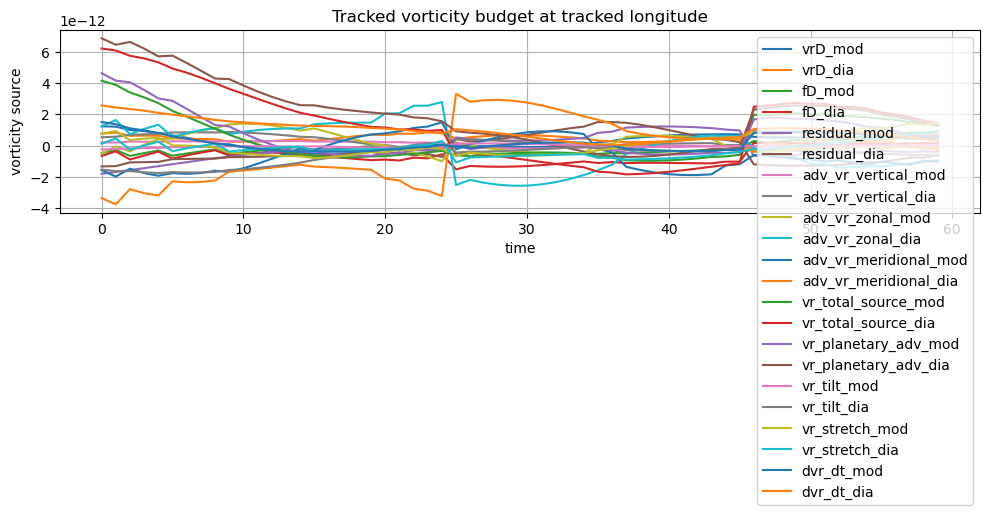

In [166]:
# ...existing code...
from matplotlib import pyplot as plt

# drop unwanted variables if present
_remove = ['vr_dia','div_dia','vr_mod','div_mod']
to_drop = [v for v in _remove if v in ds_tracked.data_vars]
if to_drop:
    ds_tracked = ds_tracked.drop_vars(to_drop)
    print("Dropped variables:", to_drop)

plt.figure(figsize=(10,4))

# plot remaining variables
for var in ds_tracked.data_vars:
    ds_tracked[var].plot(label=var)

plt.title('Tracked vorticity budget at tracked longitude')
plt.xlabel('time')
plt.ylabel('vorticity source')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
# ...existing code...

In [159]:
# ...existing code...
from matplotlib import pyplot as plt

# drop unwanted variables if present
_remove = ['vr_dia','div_dia','vr_mod','div_mod']
to_drop = [v for v in _remove if v in ds_tracked.data_vars]
if to_drop:
    ds_tracked = ds_tracked.drop_vars(to_drop)
    print("Dropped variables:", to_drop)

plt.figure(figsize=(10,4))

# plot remaining variables
for var in ds_tracked.data_vars:
    ds_tracked[var].mean(dim='time').plot(label=var)

plt.title('Tracked vorticity budget at tracked longitude')
plt.xlabel('time')
plt.ylabel('vorticity source')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
# ...existing code...

TypeError: No numeric data to plot.

<Figure size 1000x400 with 0 Axes>

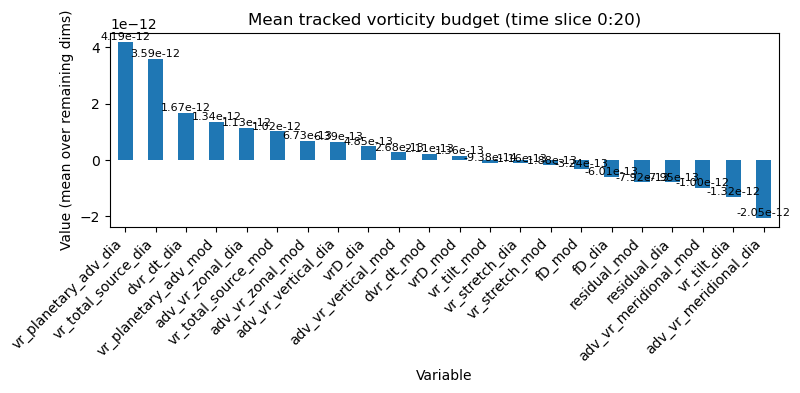

In [167]:
# ...existing code...

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ensure ds_tracked_mean exists
# ds_tracked_mean = ds_tracked.isel(time=slice(0,20)).mean(dim='time')

# Build a scalar value per variable (collapse lon/level dims if present)
vals = {}
for v in ds_tracked_mean.data_vars:
    da = ds_tracked_mean[v]
    # reduce any remaining non-scalar dims by mean
    if da.ndim > 0:
        val = float(np.nanmean(da.values))
    else:
        val = float(da.values)
    vals[v] = val

# Create a pandas Series for easy plotting
s = pd.Series(vals).sort_values(ascending=False)

plt.figure(figsize=(8,4))
ax = s.plot(kind='bar', color='C0')
ax.set_title('Mean tracked vorticity budget (time slice 0:20)')
ax.set_ylabel('Value (mean over remaining dims)')
ax.set_xlabel('Variable')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# add value labels on bars
for p in ax.patches:
    h = p.get_height()
    ax.annotate(f'{h:.2e}', (p.get_x()+p.get_width()/2., h),
                ha='center', va='bottom', fontsize=8, rotation=0)

plt.show()
# ...existing code...

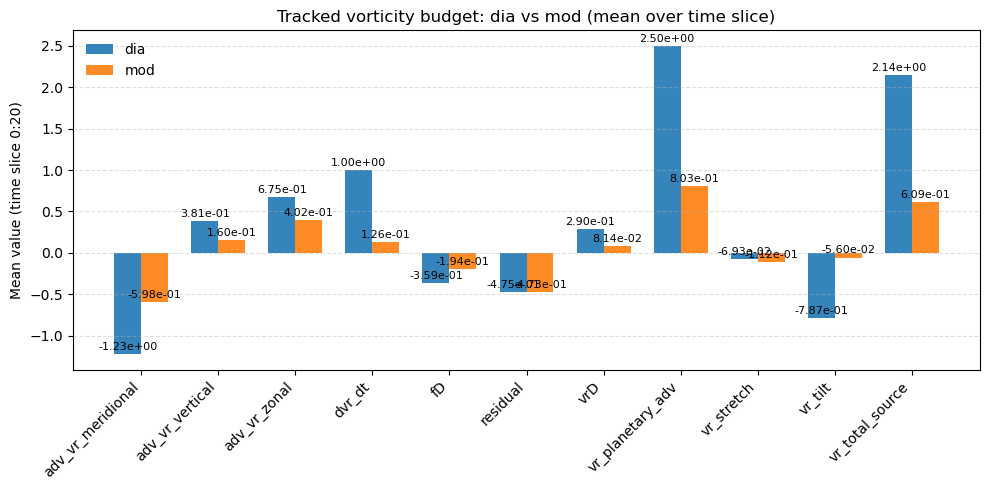

In [ ]:
# ...existing code...

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# use the same time-slice as before
ds_slice_raw = ds_tracked.isel(time=slice(0,20))
ds_slice = ds_slice_raw/ds_slice_raw['dvr_dt_dia'].mean(dim='time')

# collect mean and std (collapse all remaining dims)
vals = {}
errs = {}
for v in ds_slice.data_vars:
    arr = ds_slice[v].values
    vals[v] = float(np.nanmean(arr)) if np.isfinite(arr).any() else np.nan
    errs[v] = float(np.nanstd(arr)) if np.isfinite(arr).any() else 0.0

# split into dia and mod groups by suffix
dia = {k[:-4]: vals[k] for k in vals if k.endswith('_dia')}
mod = {k[:-4]: vals[k] for k in vals if k.endswith('_mod')}
dia_err = {k[:-4]: errs[k] for k in errs if k.endswith('_dia')}
mod_err = {k[:-4]: errs[k] for k in errs if k.endswith('_mod')}

# build DataFrame aligning base variable names
bases = sorted(set(dia.keys()) | set(mod.keys()))
df = pd.DataFrame(index=bases, data={
    'dia': [dia.get(b, np.nan) for b in bases],
    'mod': [mod.get(b, np.nan) for b in bases],
    'dia_err': [dia_err.get(b, 0.0) for b in bases],
    'mod_err': [mod_err.get(b, 0.0) for b in bases],
})

# plot grouped bar chart
fig, ax = plt.subplots(figsize=(10,5))
width = 0.35
x = np.arange(len(df.index))

ax.bar(x - width/2, df['dia'], width, label='dia', color='#1f77b4', alpha=0.9)
ax.bar(x + width/2, df['mod'], width, label='mod', color='#ff7f0e', alpha=0.9)

# styling
ax.set_xticks(x)
ax.set_xticklabels(df.index, rotation=45, ha='right')
ax.set_ylabel('Mean value (time slice 0:20)')
ax.set_title('Tracked vorticity budget: dia vs mod (mean over time slice)')
ax.grid(axis='y', linestyle='--', alpha=0.4)
ax.legend(frameon=False)

# annotate values
for xi, (d, m) in enumerate(zip(df['dia'], df['mod'])):
    if not np.isnan(d):
        ax.text(xi - width/2, d + 0.01*np.nanmax(df[['dia','mod']].values), f'{d:.2e}', ha='center', va='bottom', fontsize=8)
    if not np.isnan(m):
        ax.text(xi + width/2, m + 0.01*np.nanmax(df[['dia','mod']].values), f'{m:.2e}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()
# ...existing code...

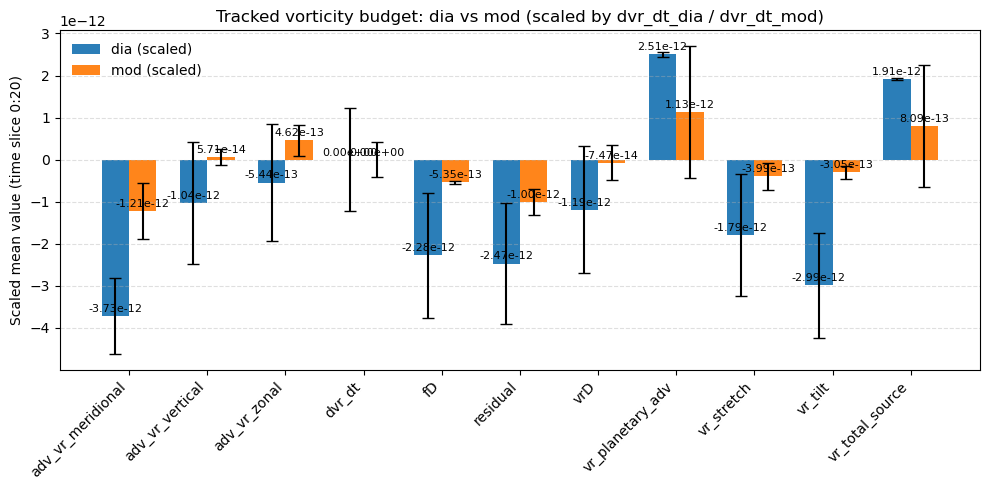

scale_dia=1.674e-12, scale_mod=2.110e-13


In [174]:
# ...existing code...

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# use same time-slice
ds_slice_raw = ds_tracked.isel(time=slice(0,20))

# get scalar scale factors (fallback to 1.0)
def _mean_scalar(da):
    a = da.mean(dim='time').values if 'time' in da.dims else da.values
    return float(np.nanmean(a))

scale_dia = _mean_scalar(ds_slice_raw['dvr_dt_dia']) if 'dvr_dt_dia' in ds_slice_raw else 1.0
scale_mod = _mean_scalar(ds_slice_raw['dvr_dt_mod']) if 'dvr_dt_mod' in ds_slice_raw else 1.0

# collect mean and std (collapse all remaining dims) then apply suffix scaling
vals = {}
errs = {}
for v in ds_slice_raw.data_vars:
    arr = ds_slice_raw[v].values
    mean_val = float(np.nanmean(arr)) if np.isfinite(arr).any() else np.nan
    std_val = float(np.nanstd(arr)) if np.isfinite(arr).any() else 0.0

    if v.endswith('_dia'):
        vals[v] = mean_val - scale_dia
        errs[v] = std_val - scale_dia
    elif v.endswith('_mod'):
        vals[v] = mean_val - scale_mod
        errs[v] = std_val - scale_mod
    else:
        vals[v] = mean_val
        errs[v] = std_val

# split into dia and mod groups by suffix (strip suffix)
dia = {k[:-4]: vals[k] for k in vals if k.endswith('_dia')}
mod = {k[:-4]: vals[k] for k in vals if k.endswith('_mod')}
dia_err = {k[:-4]: errs[k] for k in errs if k.endswith('_dia')}
mod_err = {k[:-4]: errs[k] for k in errs if k.endswith('_mod')}

# build DataFrame aligning base variable names
bases = sorted(set(dia.keys()) | set(mod.keys()))
df = pd.DataFrame(index=bases, data={
    'dia': [dia.get(b, np.nan) for b in bases],
    'mod': [mod.get(b, np.nan) for b in bases],
    'dia_err': [dia_err.get(b, 0.0) for b in bases],
    'mod_err': [mod_err.get(b, 0.0) for b in bases],
})

# pretty grouped bar plot
fig, ax = plt.subplots(figsize=(10,5))
width = 0.35
x = np.arange(len(df.index))

ax.bar(x - width/2, df['dia'], width, yerr=df['dia_err'], label='dia (scaled)', color='#1f77b4', alpha=0.95, capsize=4)
ax.bar(x + width/2, df['mod'], width, yerr=df['mod_err'], label='mod (scaled)', color='#ff7f0e', alpha=0.95, capsize=4)

ax.set_xticks(x)
ax.set_xticklabels(df.index, rotation=45, ha='right')
ax.set_ylabel('Scaled mean value (time slice 0:20)')
ax.set_title('Tracked vorticity budget: dia vs mod (scaled by dvr_dt_dia / dvr_dt_mod)')
ax.grid(axis='y', linestyle='--', alpha=0.4)
ax.legend(frameon=False)

# annotate
maxv = np.nanmax(df[['dia','mod']].values)
for xi, (d, m) in enumerate(zip(df['dia'], df['mod'])):
    if not np.isnan(d):
        ax.text(xi - width/2, d + 0.02*maxv, f'{d:.2e}', ha='center', va='bottom', fontsize=8)
    if not np.isnan(m):
        ax.text(xi + width/2, m + 0.02*maxv, f'{m:.2e}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

print(f"scale_dia={scale_dia:.3e}, scale_mod={scale_mod:.3e}")
# ...existing code...